In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from subprocess import check_output, run
import os

!pip install keras
!pip install h5py
!pip install kaggle-cli
!apt-get install unzip

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

import h5py
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17686728728922282889
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 310116352
locality {
  bus_id: 1
}
incarnation: 16383079556549097880
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# Let's get the data from kaggle

In [11]:
# Get data
username = "USERNAME"
password = "PASSWORD"
competition = "NAME_OF_COMPETITION"

!kg download -u $username -p $password -c $competition

# Unzip data
!unzip -o '*.zip' -d "input"

# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print("#############\n", check_output(["ls", "-l", "input"]).decode("utf8"))

downloading https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/download/sample_submission.csv.zip

sample_submission.csv.zip already downloaded !
downloading https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/download/test.csv.zip

test.csv.zip already downloaded !
downloading https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/download/train.csv.zip

train.csv.zip already downloaded !
Archive:  sample_submission.csv.zip
  inflating: input/sample_submission.csv  

Archive:  test.csv.zip
  inflating: input/test.csv          

Archive:  train.csv.zip
  inflating: input/train.csv         

3 archives were successfully processed.
#############
 total 132272
-rw-r--r-- 1 root root  6279782 Jan 18 21:24 sample_submission.csv
-rw-r--r-- 1 root root 60354593 Jan 18 21:24 test.csv
-rw-r--r-- 1 root root 68802655 Jan 18 21:24 train.csv



In [0]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")
train = train.sample(frac=1)

In [0]:
list_sentences_train = train["comment_text"].fillna("CVxTz").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("CVxTz").values

In [0]:
max_features = 20000
maxlen = 100

In [0]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
def get_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="selu")(x)
    x = Dropout(0.15)(x)
    x = Dense(20, activation="selu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [17]:
model = get_model()
batch_size = 4096
epochs = 50

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 100)          71600     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
__________

In [18]:
file_path = "weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)


callbacks_list = [checkpoint, early] #early

history = model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

Train on 143613 samples, validate on 15958 samples
Epoch 1/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.3405 - acc: 0.9261
Epoch 00001: val_loss improved from inf to 0.14464, saving model to weights_base.best.hdf5
143613/143613 [==============================] - 42s 291us/step - loss: 0.3402 - acc: 0.9262 - val_loss: 0.1446 - val_acc: 0.9639
Epoch 2/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.1558 - acc: 0.9624
Epoch 00002: val_loss improved from 0.14464 to 0.13758, saving model to weights_base.best.hdf5
143613/143613 [==============================] - 41s 285us/step - loss: 0.1558 - acc: 0.9623 - val_loss: 0.1376 - val_acc: 0.9639
Epoch 3/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.1421 - acc: 0.9631
Epoch 00003: val_loss improved from 0.13758 to 0.11148, saving model to weights_base.best.hdf5
143613/143613 [==============================] - 41s 285us/step - loss: 0.1421 - acc: 0.9631 - val_loss: 0.1115 - val

143360/143613 [============================>.] - ETA: 0s - loss: 0.0709 - acc: 0.9777
Epoch 00005: val_loss improved from 0.07595 to 0.05773, saving model to weights_base.best.hdf5
143613/143613 [==============================] - 41s 286us/step - loss: 0.0709 - acc: 0.9777 - val_loss: 0.0577 - val_acc: 0.9801
Epoch 6/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0594 - acc: 0.9804
Epoch 00006: val_loss improved from 0.05773 to 0.05449, saving model to weights_base.best.hdf5
143613/143613 [==============================] - 41s 285us/step - loss: 0.0594 - acc: 0.9804 - val_loss: 0.0545 - val_acc: 0.9809
Epoch 7/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0537 - acc: 0.9814
Epoch 00007: val_loss improved from 0.05449 to 0.05205, saving model to weights_base.best.hdf5
143613/143613 [==============================] - 41s 286us/step - loss: 0.0537 - acc: 0.9814 - val_loss: 0.0521 - val_acc: 0.9818
Epoch 8/50
143360/143613 [===================

143360/143613 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9828
Epoch 00009: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0487 - acc: 0.9828 - val_loss: 0.0527 - val_acc: 0.9815
Epoch 10/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0463 - acc: 0.9833
Epoch 00010: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0463 - acc: 0.9833 - val_loss: 0.0532 - val_acc: 0.9806
Epoch 11/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9835
Epoch 00011: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0454 - acc: 0.9835 - val_loss: 0.0518 - val_acc: 0.9816
Epoch 12/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9837
Epoch 00012: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0447

143360/143613 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9838
Epoch 00013: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0446 - acc: 0.9838 - val_loss: 0.0533 - val_acc: 0.9807
Epoch 14/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9833
Epoch 00014: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0469 - acc: 0.9833 - val_loss: 0.0518 - val_acc: 0.9816
Epoch 15/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9840
Epoch 00015: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0440 - acc: 0.9840 - val_loss: 0.0527 - val_acc: 0.9813
Epoch 16/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9845
Epoch 00016: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0422

143360/143613 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9850
Epoch 00017: val_loss did not improve
143613/143613 [==============================] - 41s 284us/step - loss: 0.0406 - acc: 0.9850 - val_loss: 0.0556 - val_acc: 0.9811
Epoch 18/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9853
Epoch 00018: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0395 - acc: 0.9853 - val_loss: 0.0559 - val_acc: 0.9806
Epoch 19/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9857
Epoch 00019: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0383 - acc: 0.9857 - val_loss: 0.0566 - val_acc: 0.9801
Epoch 20/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9861
Epoch 00020: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0375

143360/143613 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9863
Epoch 00021: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0367 - acc: 0.9863 - val_loss: 0.0580 - val_acc: 0.9804
Epoch 22/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9868
Epoch 00022: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0354 - acc: 0.9868 - val_loss: 0.0596 - val_acc: 0.9803
Epoch 23/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9871
Epoch 00023: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0344 - acc: 0.9871 - val_loss: 0.0610 - val_acc: 0.9804
Epoch 24/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9875
Epoch 00024: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0336

143360/143613 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9877
Epoch 00025: val_loss did not improve
143613/143613 [==============================] - 41s 284us/step - loss: 0.0329 - acc: 0.9877 - val_loss: 0.0630 - val_acc: 0.9796
Epoch 26/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9879
Epoch 00026: val_loss did not improve
143613/143613 [==============================] - 41s 284us/step - loss: 0.0322 - acc: 0.9879 - val_loss: 0.0655 - val_acc: 0.9803
Epoch 27/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9881
Epoch 00027: val_loss did not improve
143613/143613 [==============================] - 41s 284us/step - loss: 0.0315 - acc: 0.9881 - val_loss: 0.0652 - val_acc: 0.9786
Epoch 28/50
143360/143613 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9883
Epoch 00028: val_loss did not improve
143613/143613 [==============================] - 41s 285us/step - loss: 0.0312

In [19]:
print("Loading best weights from: {}".format(file_path))

model.load_weights(file_path)
print("Loaded weights. Predicting...")

y_test = model.predict(X_te, 
                      verbose=1,
                      batch_size=batch_size)
print("Done. Generating submission...")

sample_submission = pd.read_csv("./input/sample_submission.csv")
sample_submission[list_classes] = y_test

sample_submission.to_csv("submission.csv", index=False)
print("Done. Submitting...")

!kg submit submission.csv -u $username -p $password -c $competition -m "Vanilla LSTM trained on a K80"

Loading best weights from: weights_base.best.hdf5
Loaded weights. Predicting...
153164/153164 [==============================] - 8s 53us/step
Done. Generating submission...
Done. Submitting...
0.073


In [20]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


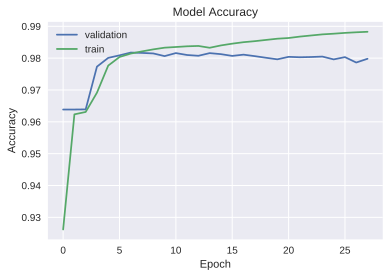

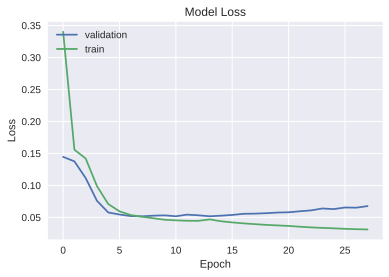

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# summarize history for accuracy
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['validation', 'train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['validation', 'train'], loc='upper left')
plt.show()